<font size=+2 color="pink"><center><b>COVID19 Tweets - Sentiment & Geographical Analysis</b></center></font>


![](https://pbs.twimg.com/profile_images/1308010958862905345/-SGZioPb_400x400.jpg) 

# Introduction

<a id="1"></a>
    
<font size="+2" color="pink"><b>1. Library</b></font><br>

Install and import necessary libraries - Numpy,Ploltly,Sklearn,NLTK,Tensorflow

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kazanova/sentiment140 -f training.1600000.processed.noemoticon.csv

 87% 70.0M/80.9M [00:00<00:00, 117MB/s]
100% 80.9M/80.9M [00:00<00:00, 137MB/s]


In [ ]:
! unzip training.1600000.processed.noemoticon.csv

Archive:  training.1600000.processed.noemoticon.csv.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import numpy as np 
import pandas as pd 
import os
import itertools

#plots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.util import ngrams


from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

import re
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords

import requests
import json

<a id="1"></a>
    
<font size="+2" color="pink"><b>2. Data</b></font><br>

The main data  for this analysis and sentiment prediction is based on [Gabriel dataset](https://www.kaggle.com/gpreda/covid19-tweets)

[Kazanova dataset](https://www.kaggle.com/kazanova/sentiment140) with 1.6 milllion tweets will be used for modeling.This dataset has target feature - sentiment as 0 & 4 (0 - Negative , 4 - Positive) which will be relabeled as (0 & 1)

We wil be scaling positive and negative emotions in our covid tweet data through predictions.

**Postive emotions** - Hope, Pride, Interest, Joy, Satisfaction, Happy etc <br>
**Negative emotions** - Fear, Anger, Disgust, Sadness, Rude etc

In [ ]:
covid=pd.read_csv('covid19_tweets.csv')

sentiment=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None,names=['target','id','time','query','usr','text'])
# Useful for code matching with countries - Plotly Chlorepeth MAP
country_code=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv') 

# Below files are used for data cleaning - Retrieving countries with help of city codes/state codes...(optional)
state = json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/states.json").text)
country=json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/countries.json").text)
city=json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/cities.json").text)
us_state_code=pd.read_csv('https://worldpopulationreview.com/static/states/abbr-name.csv',names=['state_code','state'])


# All above mentioned data are functioned and retrieved in below file to get valid country name- without_country_name
#without_country_name=pd.read_csv('../input/country-tweet/without_country_name.csv',low_memory=False)
without_country_name = pd.DataFrame([state,country,city])

covid.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False


In [ ]:
print('Total tweets in this data: {}'.format(covid.shape[0]))
print('Total Unique Users in this data: {}'.format(covid['user_name'].nunique()) )

Total tweets in this data: 179108
Total Unique Users in this data: 92276


<a id="1"></a>
    
<font size="+2" color="pink"><b>3. Location</b></font><br>

Most tweeted countries on COVID matters. 

(Given that the location fields is  a mixture and noisy.I have done some data cleaning and fitted data into 'without_country_name.csv')

In [ ]:
covid['country_name']=covid['user_location'].str.split(',').str[-1]
covid['only_date']=pd.to_datetime(covid['date']).dt.date

#Keeping countries with valid country name

with_country_name=covid[covid['country_name'].isin(list(country_code['COUNTRY']))]
with_country_name['filtered_name']=covid['country_name']

In [ ]:
tweet_df=with_country_name.append(without_country_name)
tweet_state_count=tweet_df['filtered_name'].value_counts().to_frame().reset_index().rename(columns={'index':'country','filtered_name':'count'})
all_tweet_location=pd.merge(tweet_state_count,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",how="left")
all_tweet_location=all_tweet_location[all_tweet_location['COUNTRY'].notnull()]
all_tweet_location[['COUNTRY','count']].head(5)

,COUNTRY,count
0,India,3876
1,United States,2455
2,United Kingdom,1210
3,Australia,966
4,Canada,846


In [ ]:
fig = go.Figure(go.Bar(
    x=all_tweet_location['COUNTRY'][:10],y=all_tweet_location['count'][:10],
    marker={'color': all_tweet_location['count'][:10], 
    'colorscale': 'sunset'},  
    text=all_tweet_location['count'][:10],
    textposition = "outside",
))
fig.update_layout(title_text='Top Countries with most tweets',xaxis_title="Countries",
                  yaxis_title="Number of Tweets ",template="plotly_white",height=700,title_x=0.5)

fig.show()

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = all_tweet_location['CODE'],
    z = all_tweet_location['count'],
    text = all_tweet_location['COUNTRY'],
    colorscale = 'rainbow', 
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = '# of Tweets',
))

fig.update_layout(
    title_text='Tweets over the world - ({} - {}) '.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),title_x=0.5,
    geo=dict(
        showframe=True,
        showcoastlines=False,
        
        projection_type='equirectangular',
    )
)


fig.show()

**US,India,UK,Canada & Australia** have produced more tweets.

How many tweets were posted everyday?

In [ ]:
covid['tweet_date']=pd.to_datetime(covid['date']).dt.date
tweet_date=covid['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date']=pd.to_datetime(tweet_date['date'])
tweet_date=tweet_date.sort_values('date',ascending=False)
tweet_date.head(5)

,date,count
2,2020-08-30,8375
21,2020-08-29,4077
1,2020-08-22,11555
3,2020-08-18,7500
16,2020-08-17,7500


In [ ]:
fig=go.Figure(go.Scatter(x=tweet_date['date'],
                                y=tweet_date['count'],
                               mode='markers+lines',
                               name="Submissions",
                               marker_color='pink'))

fig.update_layout(
    title_text='Tweets per Day : ({} - {}) '.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),template="plotly_white",
    title_x=0.5)

fig.show()


Hashtag

In [ ]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
covid['hash']=covid['text'].apply(lambda x:find_hash(x))

In [ ]:
hastags=list(covid[(covid['hash'].notnull())&(covid['hash']!="")]['hash'])
hastags = [each_string.lower() for each_string in hastags]
hash_df=dict(Counter(hastags))
top_hash_df=pd.DataFrame(list(hash_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_hash_df.head(4)

,word,count
0,covid19,45719
2,coronavirus covid19,1367
26,covid19 coronavirus,917
24,coronavirus,878


In [ ]:
fig = go.Figure(go.Bar(
    x=top_hash_df['word'],y=top_hash_df['count'],
    marker={'color': top_hash_df['count'], 
    'colorscale': 'purpor'},  
    text=top_hash_df['count'],
    textposition = "outside",
))
fig.update_layout(title_text='Top Trended Hastags',xaxis_title="Hashtags ",
                  yaxis_title="Number of Tags ",template="plotly_white",height=700,title_x=0.5)
fig.show()

Mention

In [ ]:
def find_at(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
covid['mention']=covid['text'].apply(lambda x:find_at(x))

In [ ]:
mentions=list(covid[(covid['mention'].notnull())&(covid['mention']!="")]['mention'])
mentions = [each_string.lower().split() for each_string in mentions]
mentions=list(itertools.chain.from_iterable(mentions))
mention_df=dict(Counter(mentions))
top_mention_df=pd.DataFrame(list(mention_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_mention_df.head(10)

,word,count
5,realdonaldtrump,3998
186,who,714
115,gop,470
87,joebiden,420
257,potus,407
166,borisjohnson,397
258,youtube,386
140,narendramodi,356
193,cnn,325
42,whitehouse,290


In [ ]:
fig = go.Figure(go.Bar(
    x=top_mention_df['word'],y=top_mention_df['count'],
    marker={'color': top_mention_df['count'], 
    'colorscale': 'purpor'},  
    text=top_mention_df['count'],
    textposition = "outside",
))

fig.update_layout(title_text='Top Trended Hastags ',xaxis_title="Hashtags",
                  yaxis_title="Number of Tags ",template="plotly_white",height=700,title_x=0.5)
fig.show()

most used word 

In [ ]:
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line

def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_thi_amp_ha_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line

In [ ]:
covid['refine_text']=covid['text'].str.lower()
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_tag(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_mention(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_hash(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_newline(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_url(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_number(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_punct(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:text_strip(x))

covid['text_length']=covid['refine_text'].str.split().map(lambda x: len(x))

In [ ]:
fig = go.Figure(data=go.Violin(y=covid['text_length'], box_visible=True, line_color='black',
                               meanline_visible=True, fillcolor='royalblue ', opacity=0.6,
                               x0='Tweet Text Length '))

fig.update_layout(yaxis_zeroline=False,title="Distribution of Text length ",template='ggplot2')
fig.show()

Text(0.5, 1.0, 'Most Used Words in Comments ')

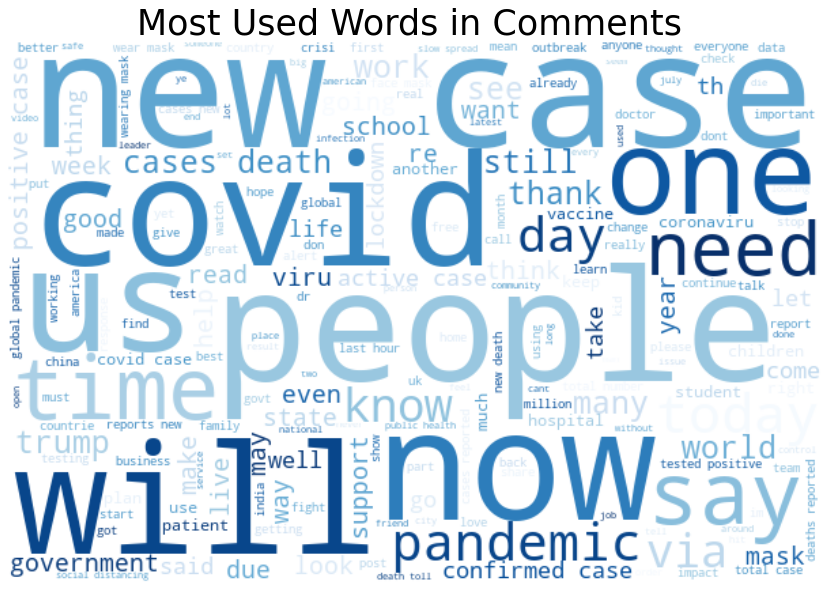

In [ ]:
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='white',colormap="Blues", 
                        width=600,height=400).generate(" ".join(covid['refine_text']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Used Words in Comments ',fontsize=35)

N-gram

In [ ]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(covid['refine_text'],(1,1),20)
bigram_df=ngram_df(covid['refine_text'],(2,2),20)
trigram_df=ngram_df(covid['refine_text'],(3,3),20)

In [ ]:
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "pink"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "pink"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "pink"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,
                  height=1200,template="plotly_white")
fig.show()

* **new,people,pandemic** are most used single word.
* **cases death,tested postive and active cases** are most used bigrams.
* **cases new deaths,help slow spread,slow spread indentity** are most used trigrams

All observed words are biased towards covid detection and admission of patients.People tend to worry lot about other peoples around.

<a id="1"></a>
    
<font size="+2" color="pink"><b>4. Modelling</b></font><br>

I will be using 40% of the data to train.I have optimized the text by removing noisy and unwanted characters present in tweet.

In [ ]:
sentiment=sentiment.sample(int(sentiment.shape[0]*0.4))
sentiment=sentiment[['text','target']]
sentiment['emotion']=np.where(sentiment['target']==0,'negative',np.where(sentiment['target']==2,'neutral',np.where(sentiment['target']==4,'postitive',"none")))
sentiment['target']=np.where(sentiment['target']==4,1,sentiment['target'])

In [ ]:
# Optimizing text
sentiment['refine_text']=sentiment['text'].str.lower()
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_tag(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_mention(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_hash(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_newline(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_url(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_number(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_punct(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:text_strip(x))
sentiment['text_length']=sentiment['refine_text'].str.split().map(lambda x: len(x))

In [ ]:
# Removing stopwords
stop_words = set(stopwords.words('english'))
sentiment['refine_text'] =  sentiment['refine_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [ ]:
# Setting tha randomly
train_data=sentiment[['refine_text','target']]

train_sent=np.array(train_data['refine_text'])
train_label=np.array(train_data['target'])

x_train, x_test, y_train, y_test = train_test_split(train_sent, train_label, test_size=0.20, random_state=42)

### Tuning Parametes (Change below parameters/add or remove layers to get more accurate result)

In [ ]:
# Hyper Parameters
vocab_size = 1000
embedding_dim =16 
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

training_label=y_train
testing_label=y_test

NameError: ignored

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # convert word to numerical numbers
    tf.keras.layers.GlobalAveragePooling1D(), # average number of ?????
    tf.keras.layers.Dense(16, activation='relu'), # add non-linearity 
    tf.keras.layers.Dense(1, activation='sigmoid') # to know popularity which class

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 16,289
Trainable params: 16,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 1 # Edit here
history=model.fit(training_padded, training_label, epochs=num_epochs, validation_data=(testing_padded, testing_label))

NameError: ignored

We have almost hedged our model accuracy with validation accuracy.The model achieved around 75% accuracy which is not too good or too bad to measure.Still we can tune hyper parameters and produce more good results.

<a id="12"></a>

<font size="+2" color="pink"><b>5. Prediction</b></font><br>

In [ ]:
tweet_df['refine_text']=tweet_df['text'].str.lower()
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_tag(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_mention(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_hash(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_newline(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_url(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_number(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_punct(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:text_strip(x))
tweet_df['text_length']=tweet_df['refine_text'].str.split().map(lambda x: len(x))

In [ ]:
sen = np.array(tweet_df.refine_text)
seq = tokenizer.texts_to_sequences(sen)
padd = pad_sequences(seq, maxlen=max_length, truncating=trunc_type)
result=model.predict(padd)
validated_result=np.where(result>0.5,1,0)

In [ ]:
pred_df=pd.DataFrame({'text':tweet_df['refine_text'],'pred_sentiment':list(validated_result),'country':tweet_df['filtered_name'],'text_length':tweet_df['text_length']})
pred_df['pred_sentiment']=np.where(pred_df['pred_sentiment']>0.5,1,0)
pred_df[['text','pred_sentiment']].head(4)

,text,pred_sentiment
11,order here …,1
30,acknowledges lacks rebuilt homes and a hospita...,0
35,our ceo live with wsu talking about “the effec...,1
50,coronavirus testing fiasco st mirren have pled...,0


<a id="13"></a>

<font size="+2" color="pink"><b>6. Angry Bird vs Happy Bird</b></font><br>

We will find most frequent used words on Negative tweet & Positive tweet.

In [ ]:
from PIL import Image
import requests
from io import BytesIO



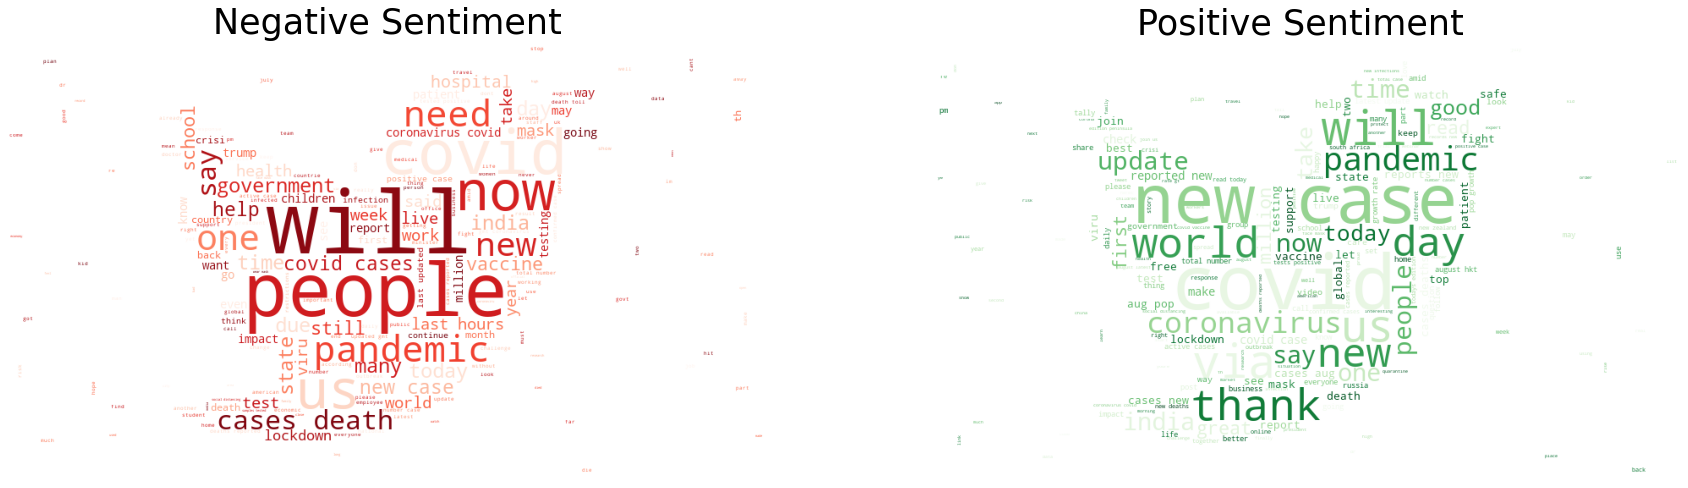

In [ ]:
response = requests.get('https://banner2.cleanpng.com/20180723/vvy/kisspng-computer-icons-clip-art-twitter-logo-vector-5b5693f7952128.7797517715324006316109.jpg')
bird = np.array(Image.open(BytesIO(response.content)))

# d = '../input/twitter/'
# bird = np.array(Image.open(d + 'twitter_mask.png'))
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==0]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==1]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive Sentiment',fontsize=35);

In [ ]:
print("Average length of Positive Sentiment tweets : {} ".format(round(pred_df[pred_df['pred_sentiment']==1]['text_length'].mean(),2)))
print("Average length of Negative Sentiment tweets : {} ".format(round(pred_df[pred_df['pred_sentiment']==0]['text_length'].mean(),2)))

Average length of Positive Sentiment tweets : 9.97 
Average length of Negative Sentiment tweets : 15.6 


In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(y=pred_df[pred_df['pred_sentiment']==1]['text_length'], box_visible=False, line_color='black',
                               meanline_visible=True, fillcolor='green', opacity=0.6,name="Positive",
                               x0='Positive')
             )

fig.add_trace(go.Violin(y=pred_df[pred_df['pred_sentiment']==0]['text_length'], box_visible=False, line_color='black',
                               meanline_visible=True, fillcolor='red', opacity=0.6,name="Negative",
                               x0='Negative')
             )

fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(title_text="Violin - Tweet Length ",
                  title_x=0.5)

fig.show()

In [ ]:
all_pos_country=pred_df[pred_df['pred_sentiment']==1]['country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})

all_pos_country_df=pd.merge(all_pos_country,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",how="left")
all_pos_country_df=all_pos_country_df[all_pos_country_df['COUNTRY'].notnull()]

In [ ]:
all_pos_country_df[['country','count']][:5]

,country,count
0,India,1230
1,United States,816
2,Switzerland,416
3,United Kingdom,363
4,South Africa,337


In [ ]:
all_neg_country=pred_df[pred_df['pred_sentiment']==0]['country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})

all_neg_country_df=pd.merge(all_neg_country,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",how="left")
all_neg_country_df=all_neg_country_df[all_neg_country_df['COUNTRY'].notnull()]

In [ ]:
all_neg_country_df[['country','count']][:5]

,country,count
0,India,2646
1,United States,1639
2,United Kingdom,847
3,Australia,654
4,Canada,585


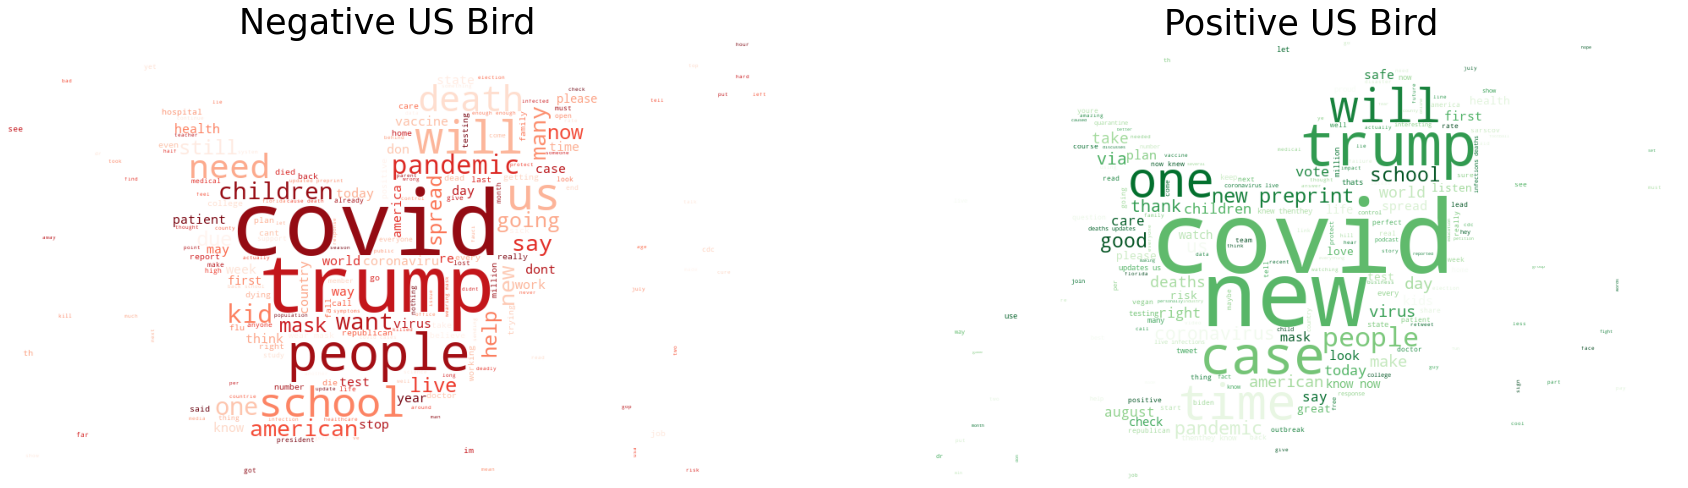

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==0)&(pred_df['country']=='United States')]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative US Bird',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==1)&(pred_df['country']=='United States')]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive US Bird',fontsize=35);

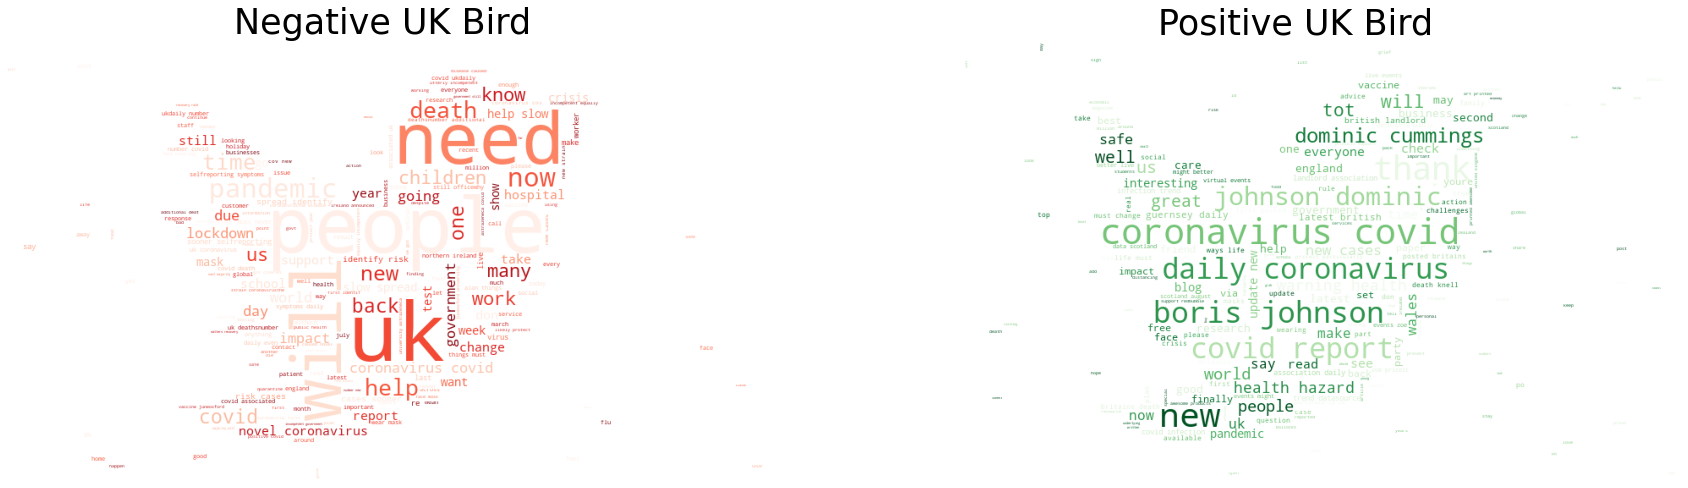

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==0)&(pred_df['country']=='United Kingdom')]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative UK Bird ',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==1)&(pred_df['country']=='United Kingdom')]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive UK Bird ',fontsize=35);

<a id="18"></a>
<font size="+2" color="pink"><b>7. Vietnamese Sentiment Analysis</b></font><br>

In [ ]:
vn_sentiment=pd.read_csv('data - data.csv',usecols=["comment","label"])
vn_sentiment.tail(5)

,comment,label
31455,Không đáng tiền.,NEG
31456,Quần rất đẹp.,POS
31457,Hàng đẹp đúng giá tiền.,POS
31458,Chất vải khá ổn.,POS
31459,"áo rất ok nhé , vải mịn , len cao cổ này phối ...",POS


In [ ]:
category = vn_sentiment['label'].unique()
category_to_id = {cate: idx for idx, cate in enumerate(category)}
id_to_category = {idx: cate for idx, cate in enumerate(category)}
print(category_to_id)
print(id_to_category)

{'POS': 0, 'NEG': 1, 'NEU': 2}
{0: 'POS', 1: 'NEG', 2: 'NEU'}


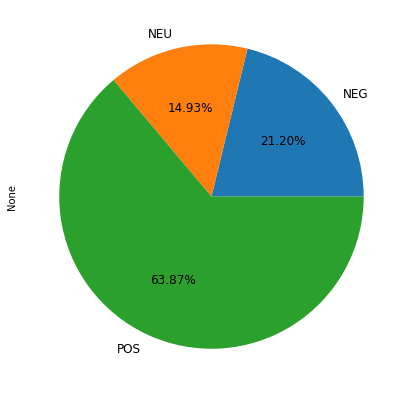

In [ ]:
data_label = vn_sentiment['label']
data_label = pd.DataFrame(data_label, columns=['label']).groupby('label').size()
data_label.plot.pie(figsize=(7, 7), autopct="%.2f%%", fontsize=12)

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 27.4MB/s 
     |████████████████████████████████| 901kB 26.9MB/s 
     |████████████████████████████████| 3.3MB 38.3MB/s 


In [ ]:
reviews = []
sentences = list(vn_sentiment['comment'])
for sen in sentences:
    reviews.append(sen)

In [ ]:
list(vn_sentiment['comment'])[0:5]
print(len(sentences))

31460


In [ ]:
len(reviews)

31460

In [ ]:
vn_sentiment.head()

,comment,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


In [ ]:
y = vn_sentiment['label']

# NEU : 0 , POS : 1 , NEG : 2
y = np.array(list(map(lambda x: 1 if x=="POS" else (2 if x == "NEG" else 0 ), y)))

In [ ]:
print(reviews[10],y[10])

Shop phục vụ rất tốt. 1


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=03c108beed7edd0b67618feca77c8082738b10581d331e233e31ad7ee7ba1896
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=bb23dd95aa7d8ab594869132a79735ed49c1eab78260e2ede57cfaa4a09ae28d
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=7a77067e223e563c5bd6cab53098181ea85d43771905bea2dedd0ba7a60009ef
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.2MB 23.1MB/s 


In [ ]:

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [ ]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [ ]:
import random 

reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]
# Word Vector - Label - length of sequence.
print(reviews_with_len[0])

[[20118, 25945, 1102, 13699, 1037, 999, 999], 1, 7]


In [ ]:
# Shuffle random dataset
random.shuffle(reviews_with_len)

In [ ]:
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]
sorted_reviews_labels
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [ ]:
BATCH_SIZE = 32 # You can edit here i.e 128
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 48), dtype=int32, numpy=
 array([[27699,  2080,  6865, ...,     0,     0,     0],
        [11834, 11320,  5063, ...,     0,     0,     0],
        [14916,  7570,  2072, ...,     0,     0,     0],
        ...,
        [ 2624,  6887,  3286, ...,     0,     0,     0],
        [ 4497, 11320,  2050, ...,  6097,  5887,  1012],
        [ 6865, 21025,  5063, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0,
        2, 2, 1, 2, 1, 1, 1, 1, 2, 1], dtype=int32)>)

In [ ]:
import math

TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [ ]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 3

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [ ]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=5)
# reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2, patience=8, min_lr=1e7)
# checkpoint = ModelCheckpoint('best_full.h5', monitor='val_f1_m', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [ ]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(121)

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model loss')

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Pylot iou-score 
plt.subplot(122)

# Get training and test loss histories
training_loss = history.history['sparse_categorical_accuracy']
test_loss = history.history['val_sparse_categorical_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Accuracy')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = tokenize_reviews(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = text_model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
sample_pred_text = ('Bớt đùa đi, dạo này tao không còn vui tính như trước đâu.')

predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)